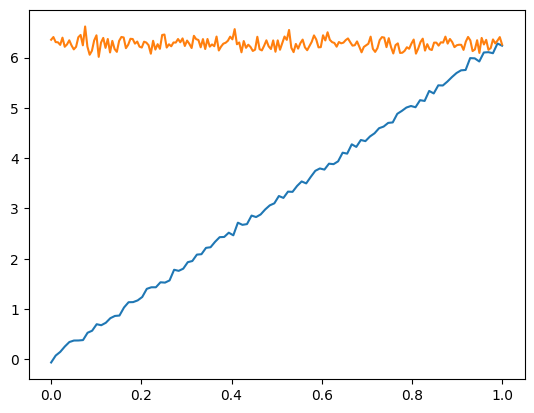

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

#kalman for orientation
omega = 2*np.pi

# generate measurements
n_sample_omega = 200
n_sample_theta = 100
omega_x = np.linspace(0,1,n_sample_omega)
omega = np.ones(n_sample_omega)*omega
sigma_omega = 0.1
omega_noise = sigma_omega*np.random.randn(n_sample_omega)
omega_noise += omega


# Generate an array of angles from 0 to 2*pi
theta_x = np.linspace(0, 1, n_sample_theta)
theta = 2*np.pi* theta_x

# Add random noise
sigma_theta = 0.05
theta_noise = sigma_theta * np.random.randn(n_sample_theta)
theta_noise = theta + theta_noise

# Plot the line
plt.plot(theta_x,theta_noise)
plt.plot(omega_x,omega_noise)
plt.show()

# Generate timestamps for 200 Hz and 100 Hz arrays
timestamps_theta = np.arange(len(theta_noise))   # Timestamps for accelerometer
timestamps_theta = timestamps_theta/timestamps_theta[-1]
timestamps_omega = np.arange(len(omega))   # Timestamps for GPS
timestamps_omega = timestamps_omega/timestamps_omega[-1]
sigma_timestamps = 0.0001

# Add small noise to the timestamps
noise_omega = np.random.normal(0, sigma_timestamps, len(timestamps_omega)) # Adjust the standard deviation as needed
timestamps_omega = timestamps_omega + noise_omega
noise_theta = np.random.normal(0, sigma_timestamps, len(timestamps_theta))
timestamps_theta = timestamps_theta + noise_theta

timestamps_omega = np.sort(timestamps_omega)
timestamps_theta = np.sort(timestamps_theta)

In [7]:
kf_gyro = KalmanFilter(dim_x=2, dim_z =1)


kf_gyro.F = np.array([[1,1],
                      [0,1]])

kf_gyro.H = np.array([[1,0]])


kf_gyro.x = np.array([theta_noise[0],omega_noise[0]])

kf_gyro.P = 100*np.eye(2)

timestamps_theta = timestamps_theta[1:]
timestamps_omega = timestamps_omega[1:]
omega_noise_copy = omega_noise[1:]
theta_noise_copy = theta_noise[1:]
xs, ts = [],  []
last_t = 0
compteur = 0

while len(theta_noise) > 0 and len(omega_noise_copy) > 0 :
    if timestamps_theta[0]<timestamps_omega[0]:
        z = theta_noise_copy[0]
        theta_noise_copy = theta_noise_copy[1:]
        t = timestamps_theta[0]
        timestamps_theta = timestamps_theta[1:]
        dt = t - last_t
        last_t = t

        kf_gyro.H = np.array([[1,0]])
        kf_gyro.R[0,0] = sigma_theta**2
    else:
        z = omega_noise_copy[0]
        omega_noise_copy = omega_noise_copy[1:]
        t = timestamps_omega[0]
        timestamps_omega = timestamps_omega[1:]
        dt = t - last_t
        last_t = t

        kf_gyro.H = np.array([[0,1]])
        kf_gyro.R[0,0] = sigma_omega**2
        
    kf_gyro.F = np.array([[1,dt],
                         [0,1]])
    
    #process noise matrix (very generic)
    
    kf_gyro.Q = np.array([
        [ sigma_omega**2 * dt**2, 0],
        [0, sigma_omega**2]])
    
    kf_gyro.predict()
    kf_gyro.update(np.array([z]))
    xs.append(kf_gyro.x.T)
    ts.append(t)


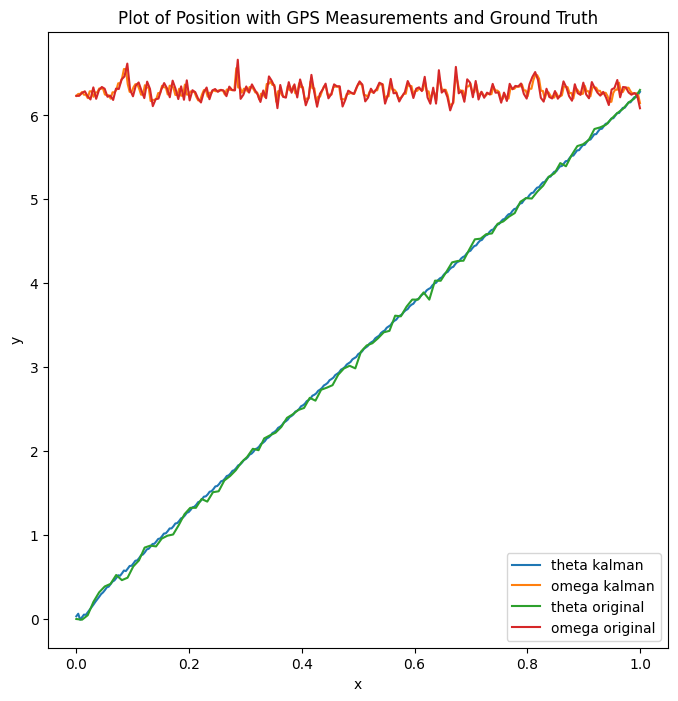

In [10]:
# Extracting individual columns
xs = np.array(xs)
theta_kalman = xs[:, 0]
omega_kalman = xs[:, 1]
x_values = np.linspace(0,1,len(omega_kalman))
# Plotting 
plt.figure(figsize=(8, 8))
plt.plot(x_values,theta_kalman, label='theta kalman')
plt.plot(x_values,omega_kalman, label='omega kalman')
plt.plot(theta_x,theta_noise,label='theta original')
plt.plot(omega_x,omega_noise,label='omega original')

plt.title('Plot of Position with GPS Measurements and Ground Truth')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()